## 12 - Time and space
>Map something where time matters. Visualize change over time—urban growth, migration, or environmental shifts. Show the relationship between time and geography. ⏳🌍

In [1]:
import cartopy.crs as ccrs
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import mapping_funcs as mf
import shapely
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from shapely import Polygon, Point
import richdem as rd
import xarray as xr
import rioxarray as rio
import xrspatial as xrs

In [2]:
# rough aoi from geojson.io
aoi = Polygon([[-95.86166721387795, 42.942999125985295],
               [-95.86166721387795, 42.555715551358105],
               [-94.43042539678062, 42.555715551358105],
               [-94.43042539678062, 42.942999125985295],
               [-95.86166721387795, 42.942999125985295]])

# get counties
counties = ox.features_from_polygon(aoi,
                                    tags={'name':['Cherokee County',
                                                  'Buena Vista County',
                                                  'Pocahontas County'
                                                  ]})

# reset aoi to be union of all counties
aoi = shapely.unary_union(counties.geometry.tolist())

# https://geodata.iowa.gov/documents/162bfe26ec4f4979a2238e03740fd077/about
so = gpd.read_file('Iowa_Stream_Order/Iowa_Stream_Order.gdb/')
clip_region = shapely.unary_union(counties.to_crs(so.crs).geometry.tolist())
so = so.clip(clip_region)
so = so.to_crs(counties.crs)

C:\Users\s1759665\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


In [ ]:
# get elevatio data and make a hillshade
dem = mf.DEM.get_copernicus_dem(aoi,
                                res=30,
                                rprj=False,
                                interp=False).squeeze().compute()
hs = xrs.hillshade(dem)

# convert to richdem DEM, and calculate flow accumulation
# rdem = rd.rdarray(dem.data, no_data=np.nan)
# rdem.geotransform = dem.rio.transform().to_gdal()
# accum = rd.FlowAccumulation(rdem, method='Dinf')

# # turn back into xr dataarray
# accum_da = xr.DataArray(accum,
#                         dims=['y','x'],
#                         coords={'y': dem.y,
#                                 'x': dem.x}).rio.write_crs(dem.rio.crs)

minx, miny, maxx, maxy = dem.rio.bounds()

# for plotting scale bar in km when using lat/lon plot
mean_lat = np.mean([miny,maxy])
mean_lon = np.mean([minx, maxx])
points = gpd.GeoSeries(
    [Point(mean_lon-0.5, mean_lat),
     Point([mean_lon+0.5, mean_lat])], crs=4326
).to_crs(32619)

dx = points[0].distance(points[1])

In [11]:
# plotting
with plt.rc_context({'font.family':['serif'],
                     'font.cursive': ['Utopia']}):
    
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},
                           figsize=[16.535, 11.693])  # a3

    hs.plot(cmap='bone',
            alpha=0.4, #  0.2 in version 1
            add_colorbar=False,
            ax=ax)
    
    ## don't plot accumlation for version 2
    # accum_da.plot.imshow(cmap='bone_r',
    #                      add_colorbar=False,
    #                      robust=True,
    #                      ax=ax,
    #                      **{'interpolation':'antialiased'})  # required otherwise network looks disconnected
    
    # plotting streams with thickness f(order)
    for order in so['Strm_order'].unique():
        so.loc[so['Strm_order']==order].plot(ax=ax,
                                             color='k',
                                             linewidth=0.15*order)
    
    # plot county names, and vertical line between 'em
    for row in counties.itertuples():
        ax.annotate(row.name,
                    xy=(row.geometry.centroid.x, row.geometry.bounds[3]),
                    ha='center',
                    va='bottom',
                    fontsize=14)
        if row.name != 'Cherokee County': ax.axvline(row.geometry.bounds[0], c='k', lw=1)

    ax.set(xlim=(minx, maxx),
           ylim=(miny, maxy))

    # scalebar
    sb = ScaleBar(dx,
                  location='lower right',
                  box_alpha=0,
                  scale_loc='left',
                  font_properties={'size':12})
    ax.add_artist(sb)

    # credits
    ax.annotate('iowan ergodicity : by:tlohde : Iowa Department of Natural Resources  \nCopernicus Global DEM (ESA, 2024); OpenStreetMap Contributors',
                xy=(0,-0.01),
                va='top',
                size=8,
                xycoords='axes fraction')

    ax.annotate('inspired by R. V. Ruhe Amer. Journal Sci., 1952',
                xy=(1,-0.01),
                va='top', ha='right',
                size=8,
                xycoords='axes fraction')
        
    # xlabel
    ax.annotate('→ time →',
                xy=(0.5, -0.01),
                va='top',
                ha='center',
                xycoords='axes fraction', 
                size=16)

    ax.set_title(None)
    ax.set_axis_off()


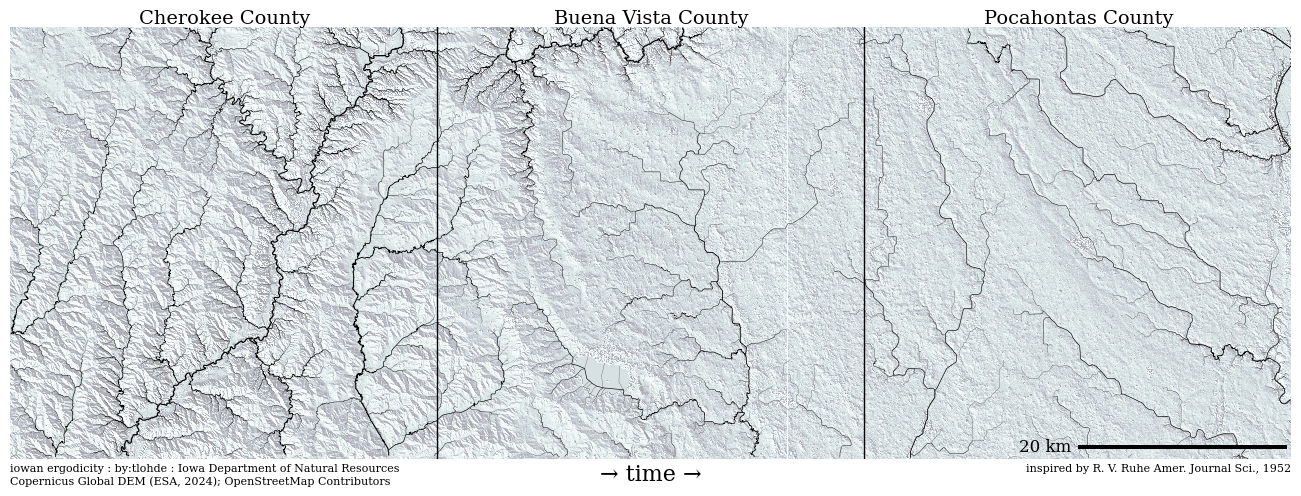

In [12]:
fig

In [13]:
fig.savefig('day12_v2.png', dpi=400, bbox_inches='tight')